In [57]:
!pip install kaggle

# IMPORTING DEPENDENCIES

This project uses various libraries for handling data, preprocessing text, and building a sentiment analysis model using LSTM. Here's a breakdown of each import and its purpose:

- `os`: For handling file system paths and operations.
- `json`: Useful if any part of the dataset or metadata is stored in `.json` format.
- `zipfile.ZipFile`: To extract zipped dataset files from Kaggle.
- `pandas`: To read, clean, and manipulate tabular data (CSV or TSV files).
- `tensorflow`: Main deep learning framework used to build and train the model.
- `sklearn.model_selection.train_test_split`: To split the dataset into training and test sets.
- `tensorflow.keras.models.Sequential`: To define a linear stack of layers for the neural network.
- `tensorflow.keras.layers.LSTM`: The core recurrent layer used for processing sequential input (text).
- `tensorflow.keras.layers.Dense`: Fully connected output layer for classification.
- `tensorflow.keras.layers.Embedding`: Turns word indices into dense vectors, suitable for input to the LSTM.
- `tensorflow.keras.preprocessing.text.Tokenizer`: Tokenizes and converts text to sequences of integers.
- `tensorflow.keras.preprocessing.sequence.pad_sequences`: Pads sequences to ensure consistent input length for LSTM processing.



In [58]:
import os
import json
from zipfile import ZipFile
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## DATA COLLECTION - Kaggle API

In [59]:
kaggle_dictionary = json.load(open("kaggle.json"))
kaggle_dictionary.keys()

dict_keys(['username', 'key'])

In [60]:
#setup kaggle credentials as environment variables.
os.environ['KAGGLE_USERNAME'] = kaggle_dictionary["username"]
os.environ['KAGGLE_KEY'] = kaggle_dictionary["key"]

In [61]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [62]:
!ls

'IMDB Dataset.csv'			 kaggle.json
 imdb-dataset-of-50k-movie-reviews.zip	 sample_data


In [63]:
#unzip the dataset file
with ZipFile("imdb-dataset-of-50k-movie-reviews.zip","r") as zip_ref:
  zip_ref.extractall()

In [64]:
!ls

'IMDB Dataset.csv'			 kaggle.json
 imdb-dataset-of-50k-movie-reviews.zip	 sample_data


# LOADING THE DATASET

In [65]:
data = pd.read_csv("IMDB Dataset.csv")

In [66]:
data.shape #50k rows and 2 columns

(50000, 2)

In [67]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [68]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## EDA AND VISUALISATION

### 📊 Sentiment Distribution Plot

To begin our analysis, we visualize the distribution of sentiments in the IMDB movie reviews dataset. This bar plot shows the count of reviews labeled as either **positive** or **negative**.

We use a `countplot` from the `seaborn` library to easily see how many examples of each sentiment are present in the dataset. This is a vital first step in any classification project to assess **class balance**, which directly impacts model performance.

#### 🔍 Why this plot is used:
- It helps **verify the balance** of classes in the dataset.
- Detects any **class imbalance** early on, which can lead to biased models.
- A **balanced dataset** usually leads to better generalization and more reliable metrics like accuracy, precision, and recall.

#### 📈 Inference:
From the plot, we observe that the dataset has **almost equal** numbers of positive and negative reviews. This indicates that the dataset is **balanced**, which is ideal for training classification models like LSTM. A balanced dataset ensures that the model won’t favor one class over the other during training and evaluation.


In [70]:
data['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


/tmp/ipython-input-3294145977.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='Set1')


Text(0.5, 1.0, 'Sentiment distribution')

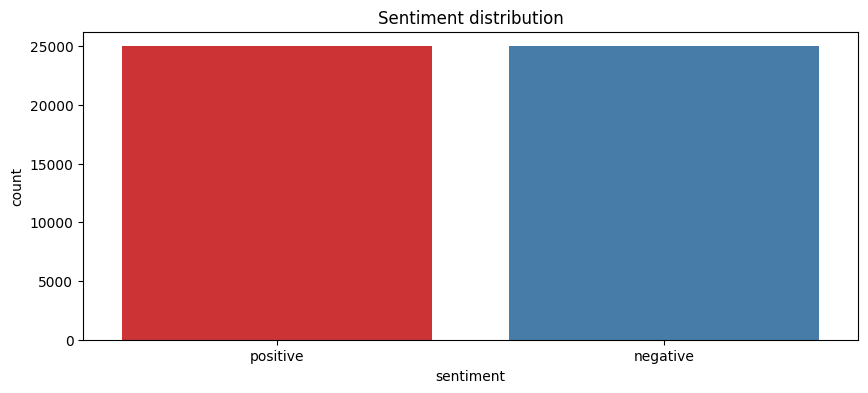

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
sns.countplot(x='sentiment', data=data, palette='Set1')
plt.title('Sentiment distribution')

In [72]:
for i in range(5):
  print("review: ", [i])
  print(data['review'].iloc[i])
  print("sentiment: ", data['sentiment'].iloc[i], '\n\n')

review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [73]:
def no_of_words(text):
  words=text.split()
  word_count = len(words)
  return word_count

In [74]:
data['word count'] = data['review'].apply(no_of_words)

In [75]:
data.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


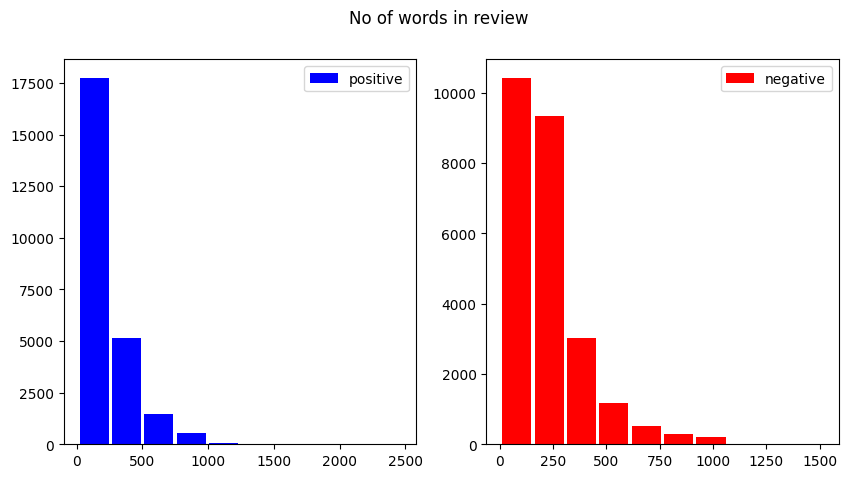

In [76]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(data[data['sentiment']=='positive']['word count'], label='positive', color='blue', rwidth=0.9)
ax[0].legend()
ax[1].hist(data[data['sentiment']=='negative']['word count'], label='negative', color='red', rwidth=0.9)
ax[1].legend()
fig.suptitle('No of words in review')
plt.show()

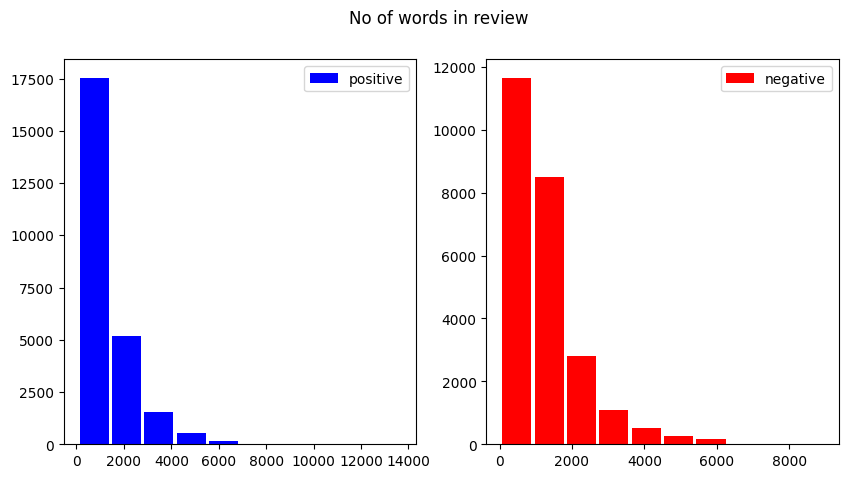

In [77]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(data[data['sentiment']=='positive']['review'].str.len(), label='positive', color='blue', rwidth=0.9)
ax[0].legend()
ax[1].hist(data[data['sentiment']=='negative']['review'].str.len(), label='negative', color='red', rwidth=0.9)
ax[1].legend()
fig.suptitle('No of words in review')
plt.show()

In [78]:
data.replace({'sentiment' : {'positive' : 1, 'negative' : 0}}, inplace=True)

/tmp/ipython-input-1225300462.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'sentiment' : {'positive' : 1, 'negative' : 0}}, inplace=True)


In [79]:
data.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [80]:
data['sentiment'].value_counts()

,count
sentiment,
1,25000
0,25000


In [81]:
#split data into training and test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


In [82]:
print(train_data.shape)
print(test_data.shape)

(40000, 3)
(10000, 3)


# DATA PREPROCESSING FOR TEXT DATA
### 🧹 Text Tokenization and Padding

Before feeding textual data into an LSTM model, we must convert it into a numerical format. This step involves **tokenizing** the text and **padding** sequences to ensure consistent input lengths.

#### 🔧 What the code does:
- `Tokenizer(num_words=5500)`: Initializes a tokenizer that keeps only the top 5500 most frequent words. This limits vocabulary size and reduces memory usage.
- `tokenizer.fit_on_texts(train_data["review"])`: Learns the word-to-index mapping from the training text data.
- `tokenizer.texts_to_sequences(...)`: Converts each review into a sequence of integers based on the tokenizer's vocabulary.
- `pad_sequences(..., maxlen=200)`: Ensures all review sequences are of the same length (200 tokens), padding shorter ones with zeros and truncating longer ones. This is crucial because LSTMs expect inputs of consistent size.

#### 💡 Why this step is essential:
- Neural networks cannot process raw text; we need numerical input.
- Padding ensures uniform input shapes for batch training with LSTM.
- Restricting vocabulary (5500 words) helps reduce overfitting and computation time.

#### 📈 Inference:
The text data is now **numerically represented** and **shape-consistent**, making it ready for embedding and LSTM modeling. Proper tokenization and padding are foundational to successful model training and impact both **accuracy** and **training efficiency**.


In [110]:
#TOKENIZE TEXT DATA
tokenizer = Tokenizer(num_words=5500)
tokenizer.fit_on_texts(train_data["review"])
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen=200)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen=200)

In [84]:
print(x_train)

[[   1 1200    4 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [85]:
print(x_test)

[[   1 1200    4 ...  205  351 3856]
 [   3 1651  595 ...   89  103    9]
 [   0    0    0 ...    2  710   62]
 ...
 [   0    0    0 ... 1641    2  603]
 [   0    0    0 ...  245  103  125]
 [   0    0    0 ...   70   73 2062]]


In [86]:
y_train = train_data['sentiment']
y_test = test_data['sentiment']

In [87]:
print(y_train)
print(y_test)

39087    0
30893    0
45278    1
16398    0
13653    0
        ..
11284    1
44732    1
38158    0
860      1
15795    1
Name: sentiment, Length: 40000, dtype: int64
33553    1
9427     1
199      0
12447    1
39489    0
        ..
28567    0
25079    1
18707    1
15200    0
5857     1
Name: sentiment, Length: 10000, dtype: int64



# MODEL ARCHITECTURE
---

#### 🧠Explanation

We build a sequential neural network for sentiment analysis using Keras. The model processes movie reviews as sequences of words and predicts whether each review is **positive** or **negative**. Here's the breakdown of the architecture and why each component is used:

---

#### 🔤 1. **Embedding Layer**
```python
model.add(Embedding(input_dim=5500, output_dim=128, input_length=200))
````

* **Purpose**: Converts each word index (integer) in a review into a dense, 128-dimensional vector.
* **Why it's first**: Neural networks can't operate on raw integers; the Embedding layer transforms discrete tokens into continuous vector space that captures **semantic meaning**.
* **input\_dim**: Vocabulary size (only the top 5500 most frequent words are considered).
* **output\_dim**: The dimension of each word vector (128).
* **input\_length**: Each review is padded or truncated to 200 tokens.

---

#### 🔁 2. **LSTM Layer**

```python
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
```

* **Purpose**: Learns the **temporal relationships** and **sequence structure** of the review (e.g., identifying negations like "not good").
* **units=128**: Number of memory cells (larger = more capacity to learn).
* **dropout=0.2**: Randomly drops 20% of input units during training to prevent overfitting.
* **recurrent\_dropout=0.2**: Randomly drops 20% of memory units between time steps to regularize long-term dependencies.

---

#### 🧮 3. **Dense Layer**

```python
model.add(Dense(1, activation='sigmoid'))
```

* **Purpose**: Final classification layer that outputs a probability between 0 and 1.
* **Why sigmoid**: This is a binary classification task (positive vs. negative), so a sigmoid activation is ideal.

---

### ✅ Why This Model Works Well

* **LSTM** can understand the flow and context of words in a review — which is crucial for sentiment (e.g., knowing "not" flips the meaning of "good").
* **Embedding** allows the model to learn semantic relationships (e.g., "excellent" and "amazing" should be treated similarly).
* **Dropout** regularizes the model and improves generalization.
* The architecture is simple, interpretable, and effective for text classification tasks with moderately sized datasets.

---

### ⚠️ Why Not CNN or Transformer?

* **CNNs** are better at capturing local patterns (like key phrases) but are less effective at modeling sequential meaning.
* **Transformers** (like BERT) are powerful but more computationally expensive and overkill for small-scale datasets.
* **LSTM** provides a good balance between power and simplicity for a binary sentiment task like this one.




In [103]:
#build the model
model= Sequential()

model.add(Embedding(input_dim=5500, output_dim=128, input_length=200))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None, 200))

In [104]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 200, 128)       │       704,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 835,713 (3.19 MB)

 Trainable params: 835,713 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

## TRAINING THE MODEL

In [106]:
model.fit(x_train,y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 207s 401ms/step - accuracy: 0.7296 - loss: 0.5265 - val_accuracy: 0.8550 - val_loss: 0.3421
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 265s 414ms/step - accuracy: 0.8549 - loss: 0.3546 - val_accuracy: 0.8648 - val_loss: 0.3358
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 239s 369ms/step - accuracy: 0.8664 - loss: 0.3290 - val_accuracy: 0.8487 - val_loss: 0.3552
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 199s 363ms/step - accuracy: 0.8944 - loss: 0.2656 - val_accuracy: 0.8601 - val_loss: 0.3522
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 208s 375ms/step - accuracy: 0.9098 - loss: 0.2284 - val_accuracy: 0.8766 - val_loss: 0.3166


# MODEL EVALUATION

In [111]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.8788 - loss: 0.3051
Test Loss: 0.3015
Test Accuracy: 0.8821


# BUILDING A PREDICTIVE SYSTEM

In [112]:
def predict_sentiment(review):
  #tokenize the data and pad the review
  sequence = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequence, maxlen=200)

  prediction = model.predict(padded_sequence)
  sentiment = 'positive' if prediction[0][0] > 0.5 else 'negative'
  return sentiment

In [113]:
#example usage
new_review ='This movies was marvellous and beautiful'
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
The sentiment of the review is: positive


In [114]:
#example usage
new_review ='This movies was not that good'
sentiment = predict_sentiment(new_review)
print(f"The sentiment of the review is: {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
The sentiment of the review is: negative
